In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
model_name = 'nasnet_fine_tuning_8clf_2'

import keras.backend as K
import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


# 导入必要的库

In [2]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 读取数据集

In [3]:
df = pd.read_csv('base/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')

display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
0,Images/skirt_length_labels/0575dc5183059223924...,skirt_length,nynnnn
1,Images/collar_design_labels/ba453aef46c484d4f3...,collar_design,nnynn
2,Images/coat_length_labels/ac448ded8b3ebd88a998...,coat_length,nnnnnynn
3,Images/coat_length_labels/206b38af4f2d55393865...,coat_length,nnnnnynn
4,Images/pant_length_labels/7da34d442a8dcc7c84a7...,pant_length,nnynnn


Counter({'coat_length': 11320,
         'collar_design': 8393,
         'lapel_design': 7034,
         'neck_design': 5696,
         'neckline_design': 17148,
         'pant_length': 7460,
         'skirt_length': 9223,
         'sleeve_length': 13299})

In [4]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'coat_length': 8,
 'collar_design': 5,
 'lapel_design': 5,
 'neck_design': 5,
 'neckline_design': 10,
 'pant_length': 6,
 'skirt_length': 6,
 'sleeve_length': 9}

## 生成 y

In [5]:
fnames = df['filename'].values
width = 331
n = len(df)
y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1

## 读取图片

In [6]:
def f(index):
    return index, cv2.resize(cv2.imread('base/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 79573/79573 [00:57<00:00, 1377.73it/s]


In [7]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [8]:
def display_images(imgs, w=8, h=4, figsize=(24, 12)):
    plt.figure(figsize=figsize)
    for i in range(w*h):
        plt.subplot(h, w, i+1)
        plt.imshow(imgs[i])

In [9]:
class Generator():
    def __init__(self, X, y, batch_size=32, aug=False):
        def generator():
            idg = ImageDataGenerator(horizontal_flip=True,
                                     rotation_range=20,
                                     zoom_range=0.2)
            while True:
                for i in range(0, len(X), batch_size):
                    X_batch = X[i:i+batch_size].copy()
                    y_barch = [x[i:i+batch_size] for x in y]
                    if aug:
                        for j in range(len(X_batch)):
                            X_batch[j] = idg.random_transform(X_batch[j])
                    yield X_batch, y_barch
        self.generator = generator()
        self.steps = len(X) // batch_size + 1

In [10]:
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

# 数据集探索

## 类别分布

In [11]:
# plt.figure(figsize=(26, 14))
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     counts = Counter(y[i].argmax(axis=-1)[np.where(y[i].any(axis=-1))])
#     pd.Series(counts).plot('bar')

### 抽样可视化

In [12]:
# plt.figure(figsize=(26, 14))
# w = 8
# h = 4
# for i in range(w*h):
#     plt.subplot(h, w, i+1)
#     index = np.random.randint(n)
#     plt.title(str([y[x][index].argmax() if y[x][index].any() else -1 for x in range(8) ]))
#     plt.imshow(X[index])
#     plt.axis('off')

# 搭建模型并训练

## 搭建模型

In [13]:
def acc(y_true, y_pred):
    index = tf.reduce_any(y_true > 0.5, axis=-1)
    res = tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    index = tf.cast(index, tf.float32)
    res = tf.cast(res, tf.float32)
    return tf.reduce_sum(res * index) / (tf.reduce_sum(index) + 1e-7)

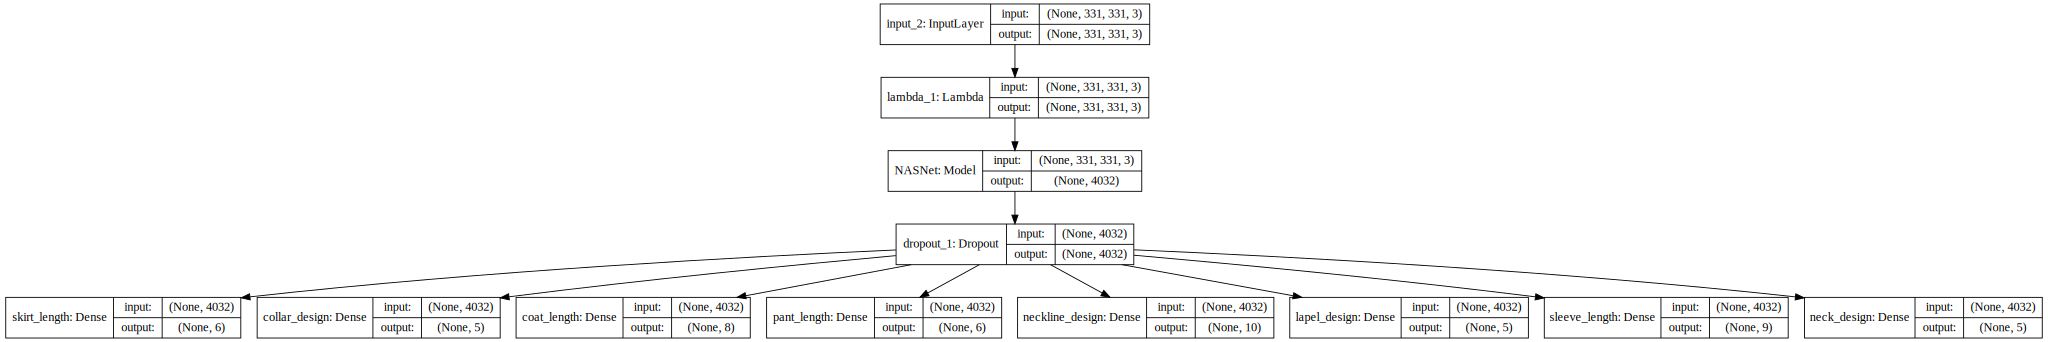

In [14]:
base_model = NASNetLarge(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(nasnet.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_simple.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model2 = multi_gpu_model(model, n_gpus)

In [16]:
# opt = SGD(1e-3, momentum=0.9, nesterov=True, decay=1e-5)

In [17]:
model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=[acc])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1990/1990 [==============================] - 3637s 2s/step - loss: 0.9191 - skirt_length_loss: 0.0899 - collar_design_loss: 0.0950 - coat_length_loss: 0.1324 - pant_length_loss: 0.0665 - neckline_design_loss: 0.2276 - lapel_design_loss: 0.0754 - sleeve_length_loss: 0.1565 - neck_design_loss: 0.0758 - skirt_length_acc: 0.7035 - collar_design_acc: 0.6344 - coat_length_acc: 0.6599 - pant_length_acc: 0.6951 - neckline_design_acc: 0.6305 - lapel_design_acc: 0.6307 - sleeve_length_acc: 0.6449 - neck_design_acc: 0.5332 - val_loss: 0.6083 - val_skirt_length_loss: 0.0512 - val_collar_design_loss: 0.0676 - val_coat_length_loss: 0.0879 - val_pant_length_loss: 0.0449 - val_neckline_design_loss: 0.1584 - val_lapel_design_loss: 0.0478 - val_sleeve_length_loss: 0.0960 - val_neck_design_loss: 0.0545 - val_skirt_length_acc: 0.5910 - val_collar_design_acc: 0.5061 - val_coat_length_acc: 0.6075 - val_pant_length_acc: 0.5270 - val_neckline_design_acc: 0.6930 - val_lapel_design_acc: 0.4736 - val_s

In [18]:
model2.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=[acc])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
1990/1990 [==============================] - 3266s 2s/step - loss: 0.3240 - skirt_length_loss: 0.0344 - collar_design_loss: 0.0373 - coat_length_loss: 0.0482 - pant_length_loss: 0.0250 - neckline_design_loss: 0.0757 - lapel_design_loss: 0.0225 - sleeve_length_loss: 0.0507 - neck_design_loss: 0.0301 - skirt_length_acc: 0.8773 - collar_design_acc: 0.8431 - coat_length_acc: 0.8804 - pant_length_acc: 0.8643 - neckline_design_acc: 0.8781 - lapel_design_acc: 0.8650 - sleeve_length_acc: 0.8903 - neck_design_acc: 0.7746 - val_loss: 0.4108 - val_skirt_length_loss: 0.0391 - val_collar_design_loss: 0.0455 - val_coat_length_loss: 0.0607 - val_pant_length_loss: 0.0323 - val_neckline_design_loss: 0.1020 - val_lapel_design_loss: 0.0334 - val_sleeve_length_loss: 0.0597 - val_neck_design_loss: 0.0381 - val_skirt_length_acc: 0.8545 - val_collar_design_acc: 0.8131 - val_coat_length_acc: 0.8499 - val_pant_length_acc: 0.8483 - val_neckline_design_acc: 0.8577 - val_lapel_design_acc: 0.8234 - val_s

In [19]:
model2.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=[acc])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
1990/1990 [==============================] - 3275s 2s/step - loss: 0.1859 - skirt_length_loss: 0.0203 - collar_design_loss: 0.0215 - coat_length_loss: 0.0262 - pant_length_loss: 0.0149 - neckline_design_loss: 0.0456 - lapel_design_loss: 0.0118 - sleeve_length_loss: 0.0269 - neck_design_loss: 0.0186 - skirt_length_acc: 0.9141 - collar_design_acc: 0.9001 - coat_length_acc: 0.9367 - pant_length_acc: 0.9030 - neckline_design_acc: 0.9278 - lapel_design_acc: 0.9106 - sleeve_length_acc: 0.9429 - neck_design_acc: 0.8237 - val_loss: 0.3961 - val_skirt_length_loss: 0.0376 - val_collar_design_loss: 0.0453 - val_coat_length_loss: 0.0584 - val_pant_length_loss: 0.0313 - val_neckline_design_loss: 0.0993 - val_lapel_design_loss: 0.0315 - val_sleeve_length_loss: 0.0570 - val_neck_design_loss: 0.0357 - val_skirt_length_acc: 0.8550 - val_collar_design_acc: 0.8224 - val_coat_length_acc: 0.8563 - val_pant_length_acc: 0.8618 - val_neckline_design_acc: 0.8626 - val_lapel_design_acc: 0.8400 - val_s

# 计算验证集准确率

In [20]:
model.save('model_%s.h5' % model_name)

In [21]:
y_pred = model2.predict(X_valid, batch_size=128, verbose=1)
a = np.array([x.any(axis=-1) for x in y_valid]).T.astype('uint8')
b = [np.where((a == np.eye(8)[x]).all(axis=-1))[0] for x in range(8)]
for c in range(8):
    y_pred2 = y_pred[c][b[c]].argmax(axis=-1)
    y_true2 = y_valid[c][b[c]].argmax(axis=-1)
    print(label_names[c], (y_pred2 == y_true2).mean())

15915/15915 [==============================] - 164s 10ms/step
skirt_length 0.8871057000553404
collar_design 0.8586102719033233
coat_length 0.8683015440508629
pant_length 0.89374185136897
neckline_design 0.8618533257532689
lapel_design 0.8917018284106891
sleeve_length 0.8756613756613757
neck_design 0.8346595932802829


In [22]:
counts = Counter(df.label_name)
counts

Counter({'coat_length': 11320,
         'collar_design': 8393,
         'lapel_design': 7034,
         'neck_design': 5696,
         'neckline_design': 17148,
         'pant_length': 7460,
         'skirt_length': 9223,
         'sleeve_length': 13299})

In [23]:
s = 0
n = 0
for c in range(8):
    y_pred2 = y_pred[c][b[c]].argmax(axis=-1)
    y_true2 = y_valid[c][b[c]].argmax(axis=-1)
    s += counts[label_names[c]] * (y_pred2 == y_true2).mean()
    n += counts[label_names[c]]
print(s / n)

0.8713447116844438


# 在测试集上预测

In [24]:
df_test = pd.read_csv('rank/Tests/question.csv', header=None)
df_test.columns = ['filename', 'label_name', 'label']

fnames_test = df_test.filename

n_test = len(df_test)
df_test.head()

,filename,label_name,label
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels,?
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels,?
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels,?
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels,?
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels,?


In [25]:
def f(index):
    return index, cv2.resize(cv2.imread('rank/'+fnames_test[index]), (width, width))

X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n_test)), total=n_test) as pbar:
        for i, img in pbar:
            X_test[i] = img[:,:,::-1]

100%|██████████| 10080/10080 [00:14<00:00, 682.05it/s]


In [26]:
y_pred = model2.predict(X_test, batch_size=128, verbose=1)

10080/10080 [==============================] - 78s 8ms/step


In [27]:
for i in range(n_test):
    problem_name = df_test.label_name[i].replace('_labels', '')
    problem_index = label_names.index(problem_name)
    probs = y_pred[problem_index][i]
    df_test.label[i] = ';'.join(np.char.mod('%.8f', probs))

In [28]:
fname_csv = 'pred_%s.csv' % model_name
fname_zip = 'pred_%s.zip' % model_name
df_test.to_csv(fname_csv, index=None, header=None)

In [29]:
%%bash -s $fname_csv $fname_zip
rm $2
zip $2 $1

  adding: pred_nasnet_fine_tuning_8clf_2.csv (deflated 69%)


rm: 无法删除'pred_nasnet_fine_tuning_8clf_2.zip': 没有那个文件或目录
